In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
# IMPORT LIBRARIES
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from datetime import datetime
from random import choice
import random
import networkx as nx
import os
import json
from pandas.io.json import json_normalize
import collections
import itertools
import warnings
import ipywidgets as widgets
from ipywidgets import HBox, Label
import requests

from ipywidgets import Layout, Button, Box, VBox

warnings.filterwarnings('ignore')

In [3]:
# FUNCTIONS

# c-lightning FUNCTIONS
# GET DATA
get_data_button = widgets.Button(description='Get Data')
def get_data(b):
    global lightning_dir
    global nodes_table
    global channels_table
    global my_node_id
    
    lightning_dir = "~/lightning/cli/"
    filename='demo_April_17'

    save_dir = "> /Users/dariuscognac/Documents/GitHub/Lightning-Network-Topological-Analysis/"
    listnodes = lightning_dir + "lightning-cli listnodes" + save_dir + filename + "list_of_nodes.json"
    listchannels = lightning_dir + "lightning-cli listchannels" + save_dir + filename + "list_of_channels.json"
    getinfo = lightning_dir + "lightning-cli getinfo" + save_dir + filename + "info.json"

#     os.system(listnodes);
#     os.system(listchannels);
#     os.system(getinfo);

    # LOAD AND FORMAT DATA
    nodes_temp = pd.read_json(filename + 'list_of_nodes.json')
    nodes_table = json_normalize(nodes_temp['nodes'])
    channels_temp = pd.read_json(filename + 'list_of_channels.json')
    channels_table = json_normalize(channels_temp['channels'])
    with open('demo_info.json') as json_data:
        info = json.load(json_data)
    my_node_id = info['id']
    
    # GET MAIN GRAPH
    global G
    G = nx.Graph()
    G.add_nodes_from(nodes_table['nodeid'])
    edges_list = [(channels_table['source'][i], channels_table['destination'][i]) for i in range(len(channels_table))]
    G.add_edges_from(edges_list)
    G = get_main_subgraph(G)
    
    print('Number of nodes = ' + str(len(G.nodes())))
    print('Number of edges (payment channels) = ' + str(len(G.edges())))
    print('node ID: ' + my_node_id)
    
    
# CONNECT TO SELECTED NODES
def connect_to_new_neighbors(new_neighbors, channel_capacity_sats):
    node_alias=[]; num_channels=[]; ip_address=[]
    for i in range(len(new_neighbors)):
        nd = nodes_table[nodes_table['nodeid']==new_neighbors[i]]
        node_alias.append(str(list(nd.alias)[0]))
        num_channels.append(len(list(G.neighbors(new_neighbors[i]))))
        ip_address.append(list(nd['addresses'])[0][0]['address'])

        print("Setting up payment channel with "+node_alias[i]+"\n");
#         connect = lightning_dir+"lightning-cli connect "+new_neighbors[i]+"@"+ip_address[i]
#         print(connect)
    #     os.system(connect);

        fund_channel = lightning_dir+"lightning-cli fundchannel "+new_neighbors[i]+" "+str(channel_capacity_sats)
#         print(fund_channel)
#         print("\n")
    #     os.system(fund_channel);
    


# FUNCTIONS FOR PICKING NEIGHBORS

def pick_highest_metric_nodes(G, centrality_measure, num_channels_to_make):    
    centrality_dict = get_centrality_dict(G, centrality_measure)
    centrality_list = [(id, centrality_dict.get(id)) for id in centrality_dict]
    sorted_by_second = sorted(centrality_list, key=lambda tup: tup[1], reverse=True) # Sort by betweenness centrality
    return [id for id, val in sorted_by_second[0: (num_channels_to_make)]]

def pick_poor_connected_nodes(G, min_degree, num_channels_to_make):
    degree = get_centrality_dict(G, 'degree')
    between_centrality = get_centrality_dict(G, 'betweenness')
    
    min_degree_nodes = set()
    for id, deg in degree.items():
        if deg > min_degree:
            min_degree_nodes.add(id)
            
    bet_centrality = [(id, between_centrality.get(id)) for id in min_degree_nodes]
    sorted_by_second = sorted(bet_centrality, key=lambda tup: tup[1]) # Sort by betweenness centrality
    return [id for id, val in sorted_by_second[0: (num_channels_to_make)]]




# PLOTTING FUNCTIONS

def plot_ego_graph(fig, ax, G, new_node_id, centrality_measure, edge_radius):
    # Create ego graphs
    ego_graph = nx.ego_graph(G, new_node_id, radius=edge_radius)

    pos=nx.spring_layout(ego_graph, seed=3)
    centrality_dict = get_centrality_dict(G, centrality_measure)

    # Draw larger extended network 
    graph1_color_vals = [centrality_dict.get(node) for node in ego_graph.nodes()]
    nx.draw_networkx_nodes(ego_graph, ax=ax, pos=pos, cmap=plt.get_cmap('viridis'), 
            node_color=graph1_color_vals, node_size=100, alpha=0.6)
    nx.draw_networkx_edges(ego_graph, ax=ax, pos=pos, alpha=0.3, edge_color='grey')

    # Draw immediate network with stronger alpha
    immediate_graph = nx.ego_graph(G, new_node_id, radius=1)
    
    graph2_color_vals = [centrality_dict.get(node) for node in immediate_graph.nodes()]
    nx.draw(immediate_graph, ax=ax, pos=pos, cmap=plt.get_cmap('viridis'), with_labels = False, 
            node_color=graph2_color_vals, node_size=400, alpha=1, edge_color='k', width = 5)
    
    # Create 'X' label for new node
    labels = {}    
    for node in immediate_graph.nodes():
        if node == new_node_id:
            #set the node name as the key and the label as its value 
            labels[node] = 'X'
    nx.draw_networkx_labels(immediate_graph, pos, labels, font_size=18, font_color='r', font_weight='bold', ax=ax)
    
    
def get_centrality_dict(G, centrality_measure):
    switcher = {
        'degree': dict(nx.degree(G)) ,
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'eccentricity': nx.eccentricity(G)
    }
    return switcher.get(centrality_measure)


def plot_centrality_hist(fig, ax, G, centrality_measure, new_node_id):
    centrality_dict = get_centrality_dict(G, centrality_measure)
    
    ax.hist(centrality_dict.values(),bins=25)
    node_centrality_value = centrality_dict.get(new_node_id)
    ax.axvline(x=node_centrality_value, color='r', linewidth=5)
    
    ax.set_yscale('log')    
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.title.set_text(centrality_measure + ' = ' + '%.2g' % node_centrality_value)
    
    
def plot_new_node_summary_fig(G, new_node_id, edge_radius):
    sns.set(font_scale=2)
    
    fig = plt.figure(0, figsize=(16,16))
    ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
    ax1 = plt.subplot2grid((3, 3), (2, 0))
    ax2 = plt.subplot2grid((3, 3), (2, 1))
    ax3 = plt.subplot2grid((3, 3), (2, 2))

    plot_ego_graph(fig, ax0, G, new_node_id, centrality_measure='betweenness', edge_radius=edge_radius)
    plot_centrality_hist(fig, ax1, G, centrality_measure='degree', new_node_id=new_node_id)
    plot_centrality_hist(fig, ax2, G, centrality_measure='betweenness', new_node_id=new_node_id)
    plot_centrality_hist(fig, ax3, G, centrality_measure='closeness', new_node_id=new_node_id)
    
    plt.show()
    
    
    
# NETWORKX FUNCTIONS

# GET THE MAIN GRAPH
def get_main_subgraph(G):
    all_sub_G = list(nx.connected_component_subgraphs(G))
    largest_sg = 0
    for i, sg in enumerate(all_sub_G):
        if sg.number_of_nodes() > largest_sg:
            largest_sg = sg.number_of_nodes()
            main_G = sg
    return main_G
    
# CREATE NEW GRAPH WITH NEW NODE AND EDGES
def make_graph_with_new_neighbors(G, new_neighbors, new_node_id):
    G_new = G.copy()
    G_new.add_node(new_node_id)
    new_edges = [(new_node_id,i) for i in new_neighbors]
    G_new.add_edges_from(new_edges)
    return(G_new)



# DISPLAY NEW NEIGHBOR INFO
def display_new_neighbors(G, new_neighbors):
    print("Here are some potential nodes to connect to:\n")
    print_neighbors(new_neighbors)
    
def print_neighbors(new_neighbors):
    node_alias=[]; num_channels=[]; ip_address=[]
    for i in range(len(new_neighbors)):
        nd = nodes_table[nodes_table['nodeid']==new_neighbors[i]]
        node_alias.append(str(list(nd.alias)[0]))
        num_channels.append(len(list(G.neighbors(new_neighbors[i]))))
        ip_address.append(list(nd['addresses'])[0][0]['address'])
        print("node ID: "+new_neighbors[i])
        print("node alias: "+node_alias[i])
        print("number of channels: "+str(num_channels[i])+"\n")


In [4]:
# GUI BUTTONS

suggest_node_button = widgets.Button(description='Suggest nodes')
def suggest_nodes(b):
    global new_neighbors
    new_neighbors = pick_highest_metric_nodes(
        G, centrality_measure=centrality_buttons.value, num_channels_to_make=payment_channel_slider.value)
    display_new_neighbors(G, new_neighbors)
suggest_node_button.on_click(suggest_nodes)


plot_suggested_nodes_button = widgets.Button(description='Plot suggested nodes')
def plot_suggested_nodes(b):    
    G_new = make_graph_with_new_neighbors(G, new_neighbors, my_node_id)
    plot_new_node_summary_fig(G_new, new_node_id=my_node_id, edge_radius=2)
plot_suggested_nodes_button.on_click(plot_suggested_nodes)


connect_to_node_button = widgets.Button(description='Connect to nodes')
def connect_nodes(b):
    connect_to_new_neighbors(new_neighbors, channel_capacity_sats=channel_capacity_text.value)
connect_to_node_button.on_click(connect_nodes)


preset_casual_button = widgets.Button(description='casual')
def preset_casual(b):
    centrality_buttons.value = 'closeness'
    payment_channel_slider.value = 2
    channel_capacity_text.value = 20000
preset_casual_button.on_click(preset_casual)


preset_business_button = widgets.Button(description='business')
def preset_business(b):
    centrality_buttons.value = 'betweenness'
    payment_channel_slider.value = 50
    channel_capacity_text.value = 10000000
preset_business_button.on_click(preset_business)


centrality_buttons = widgets.ToggleButtons(options=['closeness', 'betweenness'], value = 'closeness')
centrality_box = HBox([Label('Centrality to maximize:'), centrality_buttons])

payment_channel_slider = widgets.IntSlider(value = 2)
payment_channel_box = HBox([Label('Number of payment channels:'), payment_channel_slider])

channel_capacity_text = widgets.IntText(value = 20000)
channel_capacity_box = HBox([Label('Capacity per channel (sats):'), channel_capacity_text])

# Lightning Payment Channel Optimizer

### Get Lightning Network Data

In [5]:
get_data_button.on_click(get_data)
display(get_data_button)

Button(description='Get Data', style=ButtonStyle())

### Choose payment channel settings

In [6]:
display(preset_casual_button, preset_business_button)
display(centrality_box, payment_channel_box, channel_capacity_box)

Button(description='casual', style=ButtonStyle())

Button(description='business', style=ButtonStyle())

### Suggest nodes to form payment channels with

In [7]:
display(suggest_node_button)

Button(description='Suggest nodes', style=ButtonStyle())

### Visualize suggested payment channels

In [8]:
display(plot_suggested_nodes_button)

Button(description='Plot suggested nodes', style=ButtonStyle())

### Set up suggested payment channels

In [9]:
display(connect_to_node_button)

Button(description='Connect to nodes', style=ButtonStyle())

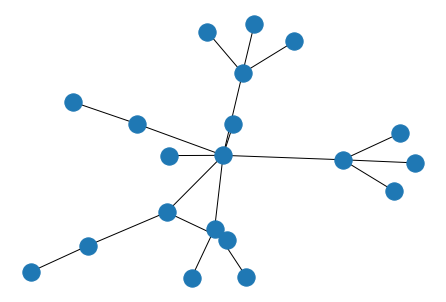

In [82]:
DB1 = nx.dual_barabasi_albert_graph(20,1,2,1)
nx.draw(DB1)

In [103]:
def plot_demo_graph(fig, ax, G, centrality_measure):
    # Create ego graphs
    pos=nx.spring_layout(G, seed=3)
    centrality_dict = get_centrality_dict(G, centrality_measure)

    # Draw larger extended network 
    graph1_color_vals = [centrality_dict.get(node) for node in G.nodes()]
    nx.draw_networkx_nodes(G, ax=ax, pos=pos, cmap=plt.get_cmap('viridis'), with_labels = True,
            node_color=graph1_color_vals, node_size=1000, alpha=1)
    nx.draw_networkx_edges(G, ax=ax, pos=pos, alpha=1, edge_color='grey')
    
    plt.show()


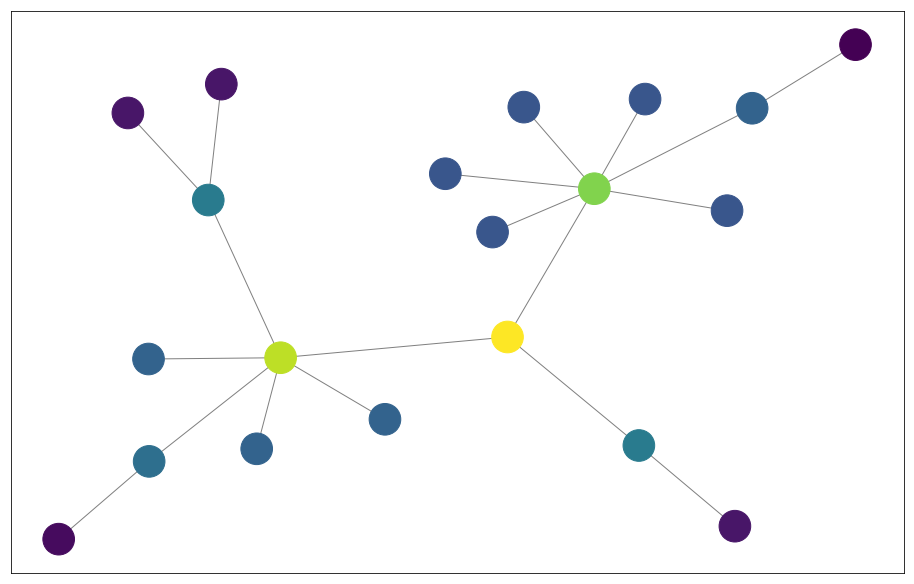

In [89]:
fig = plt.figure(0, figsize=(16,16))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
plot_demo_graph(fig, ax0, DB, centrality_measure='closeness')
    

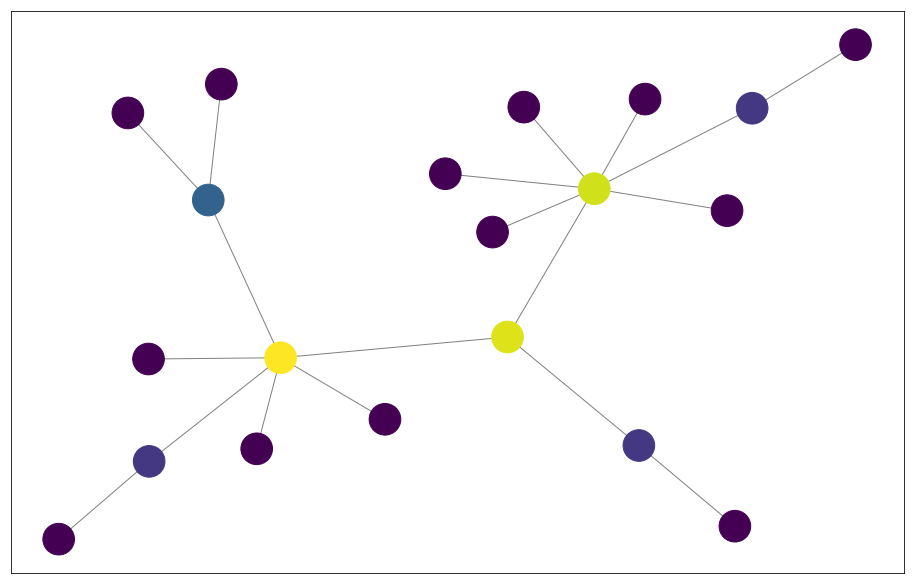

In [87]:
fig = plt.figure(0, figsize=(16,16))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
plot_demo_graph(fig, ax0, DB, centrality_measure='betweenness')

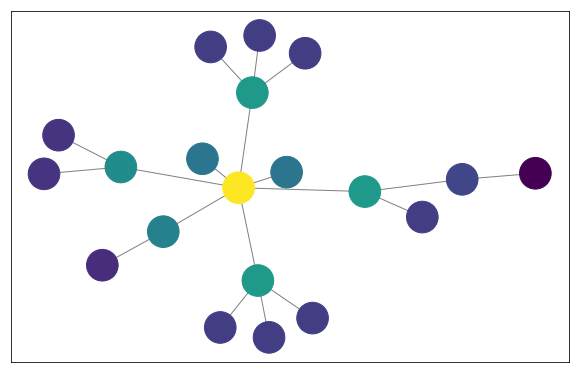

In [106]:
fig = plt.figure(0, figsize=(10,10))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
plot_demo_graph(fig, ax0, DB1, centrality_measure='closeness')
fig.savefig('closeness1.png', bbox_inches='tight')

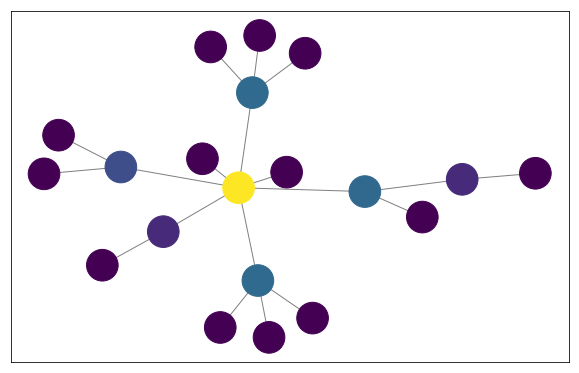

In [104]:
fig = plt.figure(0, figsize=(10,10))
ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
plot_demo_graph(fig, ax0, DB1, centrality_measure='betweenness')
fig.savefig('betweenness1.png', bbox_inches='tight')